In [300]:
# 导入一些模块
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, Lambda, concatenate, Conv1D, GRU, add, Add, LSTM,Dropout,TimeDistributed
from keras.constraints import non_neg, unit_norm
from keras.models import Model
from keras.layers import Layer
from keras.initializers import random_uniform

from keras.callbacks import EarlyStopping

In [301]:
#载入数据
#读取数据集
dataset_train=pd.read_csv("train_set.csv",infer_datetime_format=True,index_col='date')    #设置时间戳索引
dataset_test=pd.read_csv("test_set.csv",infer_datetime_format=True,index_col='date')
dataset_val = pd.read_csv("validation_set.csv",infer_datetime_format=True,index_col='date')

train_v = dataset_train.values
test_v = dataset_test.values
val_v = dataset_test.values



C:\Users\12204\AppData\Local\Temp\ipykernel_19704\1024496477.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_train=pd.read_csv("train_set.csv",infer_datetime_format=True,index_col='date')    #设置时间戳索引
C:\Users\12204\AppData\Local\Temp\ipykernel_19704\1024496477.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset_test=pd.read_csv("test_set.csv",infer_datetime_format=True,index_col='date')
C:\Users\12204\AppData\Local\Temp\ipykernel_19704\1024496477.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be rem

In [302]:
#  归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.fit_transform(dataset_test)
scaled_val = scaler.fit_transform(dataset_val)



In [303]:
# 制作滑动窗口数据集
# 将数据集使用滑动窗口方法制作成监督学习
def series_to_supervised(df,n_in=96, n_out=96):   #df.shape = (样本数,变量数)
    n_vars = df.shape[1]                          #获取变量数
    df=DataFrame(df)
    shift_data, timewindow = [], []                  
    var_names = ['HUFL','HULL','MUFL','MULL','LUFL','LULL','OT']
    for i in range(n_in, 0, -1):       # 向后shift ————>  得到[-96,-95..-1]
        shift_data.append(df.shift(i))
        timewindow += [('%s(t-%d)' % (j, i)) for j in var_names]

    for i in range(0, n_out):         # 向前shift ————>  得到[0,1,...,96]
        shift_data.append(df.shift(-i))
        timewindow += [('%s(t+%d)' % (j, i)) for j in var_names]

    agg = concat(shift_data, axis=1)
    agg.columns = timewindow
    return agg


In [304]:
pd.set_option('display.max_columns', None)
sliding_window_raw_train = series_to_supervised(scaled_train,96,96)[96:-96]      # 获得原始的滑动窗口数据集，切去nan部分
sliding_window_raw_test = series_to_supervised(scaled_test,96,96)[96:-96]      # 获得原始的滑动窗口数据集，切去nan部分
sliding_window_raw_val = series_to_supervised(scaled_val,96,96)[96:-96]      # 获得原始的滑动窗口数据集，切去nan部分


In [305]:
sliding_window_raw_train.shape

(8448, 1344)

In [306]:
# 切割数据集，分成8:2;  val 在后续fit时切分

train_X, train_y = sliding_window_raw_train.values[:,:96*7], sliding_window_raw_train.values[:,96*7:]      # 划分好x与y； 其中 x 是前96个窗口，y是后96个窗口

test_X, test_y = sliding_window_raw_test.values[:,:96*7], sliding_window_raw_test.values[:, 96*7:]  
val_X,val_y = sliding_window_raw_val.values[:,:96*7],sliding_window_raw_val.values[:,96*7:]

train_X = train_X.reshape(train_X.shape[0],96,7)
train_y = train_y.reshape(train_y.shape[0],96,7)             # reshape成 :  (样本数,步长,变量数量)
test_X = test_X.reshape(test_X.shape[0],96,7)
test_y = test_y.reshape(test_y.shape[0],96,7)
val_X = val_X.reshape(val_X.shape[0],96,7)
val_y = val_y.reshape(val_y.shape[0],96,7)
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)


(8448, 96, 7) (8448, 96, 7) (2784, 96, 7) (2784, 96, 7)


### 至此， 数据集处理完成

### 开始构建模型,步骤如下:
1.  建立SE组，包含7个lstm,用于处理每一个变量
2.  训练SE组，保存模型
3.  建立一维卷积+LSTM模型组，联合组
4.  训练联合组，保存模型
5.  加载SE组和联合组，定义聚合方法，得到最终的

In [307]:
## 创建单变量LSTM
def create_single_var_LSTM(n_units,loss,optimizer,n_in=96,n_output=96):
    model = Sequential()
    model.add(LSTM(n_units, activation='relu', return_sequences=True, input_shape=(n_in, 1)))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss=loss, optimizer=optimizer) 
    return model    


In [345]:
## 分别对每一个变量进行训练
se_model_list = [create_single_var_LSTM(100,loss='mse',optimizer='adam',n_in=96,n_output=96) for i in range(7)]

In [309]:
# 开始使用单个变量，训练每一个LSTM
# 
n_epochs = 10
n_batch_size=4
for i in range(7):
    single_var_train_X = train_X[:,:,i:i+1]
    single_var_train_y = train_y[:,:,i:i+1] 
    vval_X = val_X[:,:,i:i+1]
    vval_y = val_y[:,:,i:i+1] 
    print("-----------training var"+str(i)+"-----")
    se_model_list[i].fit(single_var_train_X, single_var_train_y, epochs=n_epochs, batch_size=n_batch_size,validation_data=(vval_X,vval_y) , verbose=1, shuffle=False)
    

-----------training var0-----
Epoch 1/10
2112/2112 [==============================] - 28s 13ms/step - loss: 0.0199 - val_loss: 0.0164
Epoch 2/10
2112/2112 [==============================] - 41s 19ms/step - loss: 0.0079 - val_loss: 0.0150
Epoch 3/10
2112/2112 [==============================] - 40s 19ms/step - loss: 0.0071 - val_loss: 0.0146
Epoch 4/10
2112/2112 [==============================] - 42s 20ms/step - loss: 0.0069 - val_loss: 0.0150
Epoch 5/10
2112/2112 [==============================] - 40s 19ms/step - loss: 0.0069 - val_loss: 0.0147
Epoch 6/10
2112/2112 [==============================] - 40s 19ms/step - loss: 0.0070 - val_loss: 0.0143
Epoch 7/10
2112/2112 [==============================] - 39s 18ms/step - loss: 0.0068 - val_loss: 0.0146
Epoch 8/10
2112/2112 [==============================] - 39s 19ms/step - loss: 0.0066 - val_loss: 0.0138
Epoch 9/10
2112/2112 [==============================] - 41s 20ms/step - loss: 0.0068 - val_loss: 0.0141
Epoch 10/10
2112/2112 [===========

In [346]:
for i in range(7):
    se_model_list[i].load_weights('se_4batch_10epch_100Units_mae'+str(i)+'.h5')

3/3 [==============================] - 0s 1ms/step


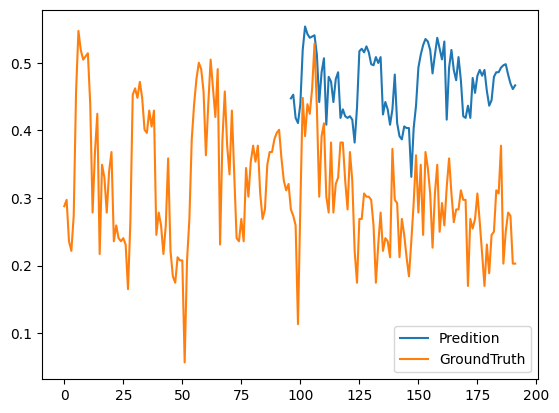

[0.2878003386062832,
 0.29722553161320964,
 0.235895391436665,
 0.22169122420722384,
 0.273596171376842,
 0.4575865998189469,
 0.5471923585786259,
 0.5189167637329044,
 0.5047125806785213,
 0.509491554901036,
 0.5141377895103898,
 0.43873621380509387,
 0.2783751455993566,
 0.36798087270915175,
 0.4245320624005947,
 0.217044997510341,
 0.3491304866952988,
 0.33014734524334294,
 0.2783751455993566,
 0.3397052936883723,
 0.36798087270915175,
 0.235895391436665,
 0.2593920041474008,
 0.24054161022107684,
 0.235895391436665,
 0.24054161022107684,
 0.23111641721415033,
 0.16514004836260515,
 0.2641709783699155,
 0.4528076255964323,
 0.46223283442830065,
 0.44816142263696235,
 0.47179078287333,
 0.44816142263696235,
 0.4009027021642271,
 0.3962564675548732,
 0.4293110366231093,
 0.4056816763867417,
 0.4293110366231093,
 0.2453205844435915,
 0.2783751455993566,
 0.2593920041474008,
 0.217044997510341,
 0.2593920041474008,
 0.35855567970222524,
 0.22169122420722384,
 0.18399044031081138,
 0.174

In [368]:
# 分别测试每一个变量的预测情况
idx = 2226
var_idx=3
vvv = se_model_list[var_idx].predict(test_X[idx,:,var_idx:var_idx+1])
vvv=vvv.reshape(96,1)
vvv.shape
# pyplot.figure()
test_y=test_y.reshape(test_y.shape[0],96,7)
# test_y.shape
combined_line = list(test_y[idx-96][:, var_idx])+list(test_y[idx][:, var_idx])
pyplot.plot([[None] for i in range(96)]+list(vvv),label='Predition')        #2016   3214
pyplot.plot(combined_line,label='GroundTruth')
pyplot.legend()
pyplot.show()
list(test_y[idx-96][:, var_idx])+list(test_y[idx][:, var_idx])


In [311]:
# se_model_list
# i=0
# for auto in se_model_list:
#     auto.save('se_4batch_10epch_100Units_mae'+str(i)+'.h5')
#     i+=1

### 至此，已经获得了对单个变量的LSTM模型组,se_model
#### 对变量5，6的效果很差，考虑删除



In [312]:
## 创造最后相乘层
class Multiply(Layer):
    RND_UNI = random_uniform(minval=0.05, maxval=1.05)

    def __init__(self, unit, **kwargs):
        super(Multiply, self).__init__(**kwargs)
        self.build(unit)

    def build(self, unit, input_shape=None):
        self.prop_weights = self.add_weight(
            name='proportion-weights',
            shape=(unit,),
            initializer=self.RND_UNI,
            trainable=True,
            constraint=non_neg()
        )
        super(Multiply, self).build(input_shape)

    def call(self, input):
        return tf.multiply(
         name='ele-wise-product',
         x=input,
         y=self.prop_weights
        )


In [313]:
## 创建CNN+LSTM, 联合 (总联合+子联合？)  HUFL

In [369]:
se_model_list

In [370]:
for i in range(7):
    se_model_list[i].load_weights('se_4batch_10epch_100Units_mae'+str(i)+'.h5')

In [316]:
se_model_list

In [386]:
# 需要传入体现训练好的se_models
def CREATE_SEPNET(se_models,n_var=7,loss='mae',n_in=96):
        x = Input(shape=(n_in, n_var)) 
        se_outputs = [
            se_models[idx](
                inputs=Lambda(
                    lambda k: k[:, :, idx]       
                )(x)
            )
            for idx in range(n_var)
        ]
        se_pred = concatenate(se_outputs)
    
        c1 = Conv1D(
            filters=1, kernel_size=1, name='Conv1D-1'
        )(x)
        c3 = Conv1D(
            filters=1, kernel_size=3, name='Conv1D-3'
        )(x)
        c5 = Conv1D(
            filters=1, kernel_size=5, name='Conv1D-5'
        )(x)

        r1 = LSTM(
            units=16, name='LSTM-1'
        )(c1)
        r3 = LSTM(
            units=16, name='LSTM-3'
        )(c3)
        r5 = LSTM(
            units=16, name='LSTM-5'
        )(c5)
        r135 = add([r1, r3, r5])
        res_pred = Dense(
            units=n_var,
            kernel_initializer='uniform', kernel_constraint=unit_norm()
        )(r135)

        # make final
        se = Multiply(
            unit=n_var, name='se-weights'
        )(se_pred)
        res = Multiply(
            unit=n_var, name='res-weights'
        )(res_pred)
        y_pred = Add()([se, res])

        model = Model(inputs=x, outputs=y_pred)
        model.compile('Adam', loss=loss)
        return model




In [409]:
sepmd = CREATE_SEPNET(se_model_list,loss='mse')
sepmd.fit(train_X,train_y,batch_size=4,epochs=15,verbose=1,validation_data=(val_X,val_y))

(None, 96, 7)


C:\Users\12204\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/15
2112/2112 [==============================] - 155s 70ms/step - loss: 45095858176.0000 - val_loss: 6779527.5000
Epoch 2/15
2112/2112 [==============================] - 140s 66ms/step - loss: nan - val_loss: nan
Epoch 3/15
2112/2112 [==============================] - 145s 69ms/step - loss: nan - val_loss: nan
Epoch 4/15
2112/2112 [==============================] - 153s 72ms/step - loss: nan - val_loss: nan
Epoch 5/15
2112/2112 [==============================] - 141s 67ms/step - loss: nan - val_loss: nan
Epoch 6/15
 109/2112 [>.............................] - ETA: 2:16 - loss: nan

KeyboardInterrupt: 

In [388]:
prd = sepmd.predict(test_X)

87/87 [==============================] - 3s 22ms/step


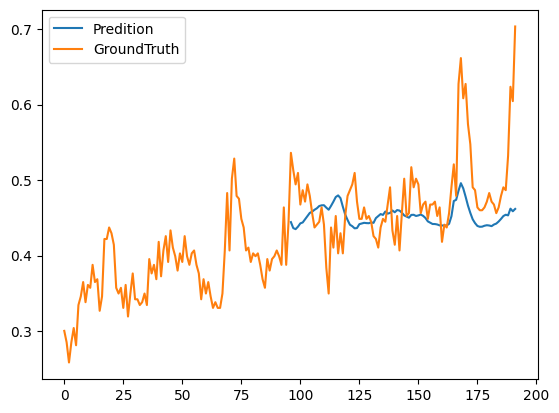

In [419]:
from keras.models import load_model
pyplot.figure()

test_y=test_y.reshape(test_y.shape[0],96,7)
wind = 1334
iddx = 6

combined_line = list(    test_y[wind-96][:, iddx])  + list(test_y[wind][:, iddx])
pyplot.plot([None]*96+   list(prd[wind][:,iddx]+0.1),label='Predition')        #2016   3214
pyplot.plot(combined_line,label='GroundTruth')
pyplot.legend()
pyplot.show()


In [321]:
train_y.shape

(8448, 96, 7)

3/3 [==============================] - 0s 0s/step


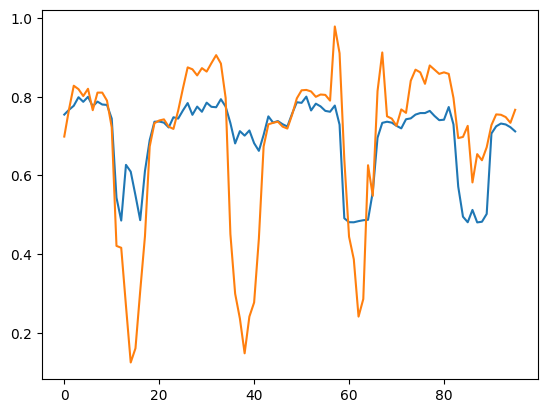

In [322]:
from keras.models import load_model
# load model from single file

var_idx=2
model1 = load_model('se_'+str(var_idx)+'.h5')


idx = 1126
qqq = model1.predict(test_X[idx,:,var_idx:var_idx+1])
qqq=qqq.reshape(96,1)
pyplot.figure()
pyplot.plot(qqq)
pyplot.plot(test_y[idx,:,var_idx])
pyplot.show()


In [323]:
test_X[idx,:,var_idx:var_idx+1]

array([[0.77355396],
       [0.79494052],
       [0.8134008 ],
       [0.85423219],
       [0.83188844],
       [0.85617394],
       [0.81050185],
       [0.83284563],
       [0.81925341],
       [0.8172843 ],
       [0.75607823],
       [0.45674827],
       [0.28765214],
       [0.56852182],
       [0.54713525],
       [0.46645701],
       [0.30515522],
       [0.549077  ],
       [0.66569125],
       [0.74245864],
       [0.7434432 ],
       [0.73857516],
       [0.71817313],
       [0.76190347],
       [0.75607823],
       [0.79204157],
       [0.82603583],
       [0.77259676],
       [0.8095173 ],
       [0.78618899],
       [0.82797758],
       [0.8085601 ],
       [0.80661835],
       [0.84449611],
       [0.8095173 ],
       [0.73663341],
       [0.65209901],
       [0.7026118 ],
       [0.68415152],
       [0.70553809],
       [0.65305622],
       [0.6219609 ],
       [0.68707781],
       [0.76578697],
       [0.73857516],
       [0.74538494],
       [0.73176536],
       [0.722